Using file: /content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv
Data rows: 610
['Feed Rate /Flute (mm/flute)', 'Feed Rate', 'Depth Of Cut (mm)', 'Spindle Speed', 'Time (Sec)', 'P (w)']
Physics proxy sample (W): [0.57645   4.1135178 1.9297283 2.4681106 1.1529   ]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

ANN test metrics -> MSE: 7058.263, MAE: 58.711, R2: 0.9440
Epoch 1/300 -> data_loss=0.546760, phys_loss=2.603466, total=0.598829, lam=0.02000
Epoch 25/300 -> data_loss=0.252785, phys_loss=2.776544, total=0.308315, lam=0.02000
Epoch 50/300 -> data_loss=0.229881, phys_loss=2.978830, total=0.289458, lam=0.01400
Epoch 75/300 -> data_loss=0.215564, phys_loss=3.220608, total=0.260652, lam=0.01400
Epoch 100/300 -> data_loss=0.205652, phys_loss=2.982927, total=0.247413, lam=0.00980
Epoch 125/300 -> data_loss=0.216059, phys_loss=3.225821, total=0.247672, lam=0.00980
Epoch 150/300 -> data_loss=0.171574, phys_loss=3.050446, total=0.201469, lam=0.00686
Epoch 175/300 -> data_loss=0.153173, p

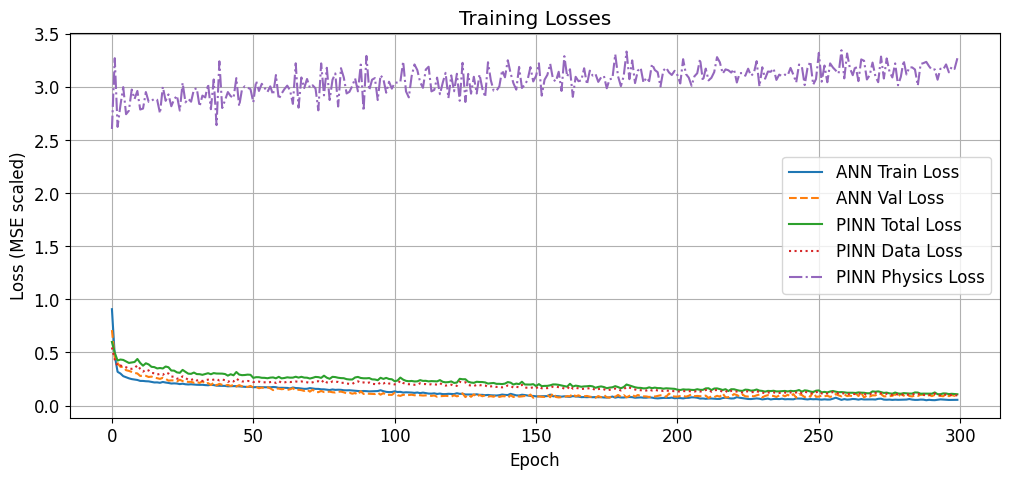

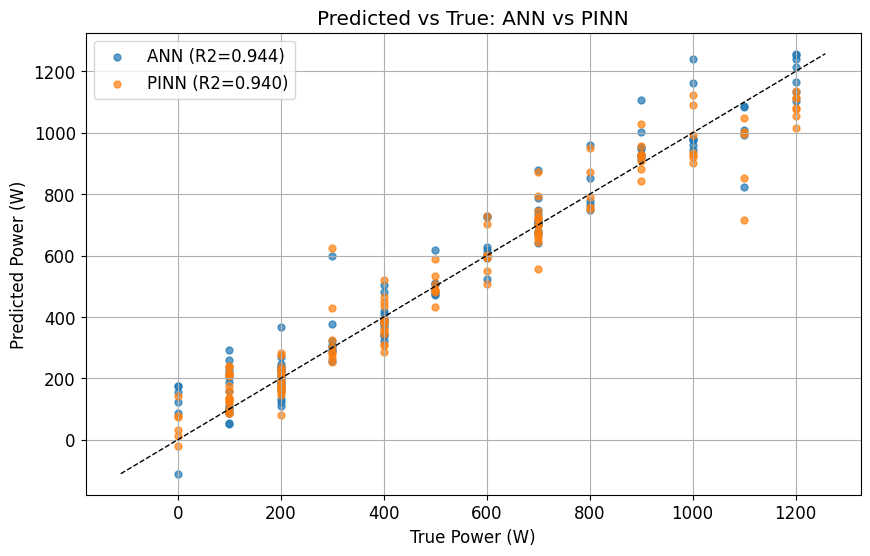

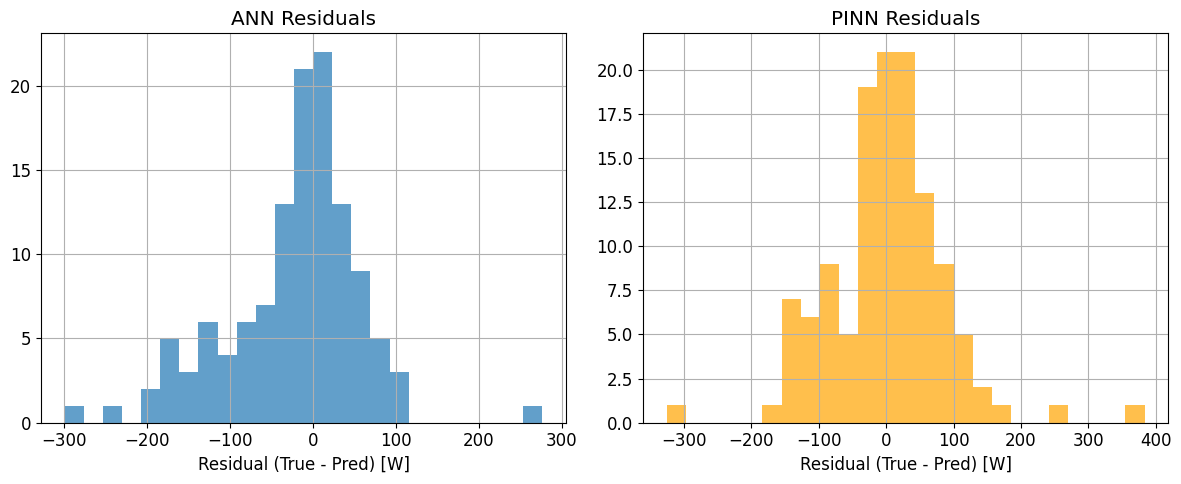

/tmp/ipython-input-3049015956.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([abs_ann, abs_pinn], labels=['ANN', 'PINN'])


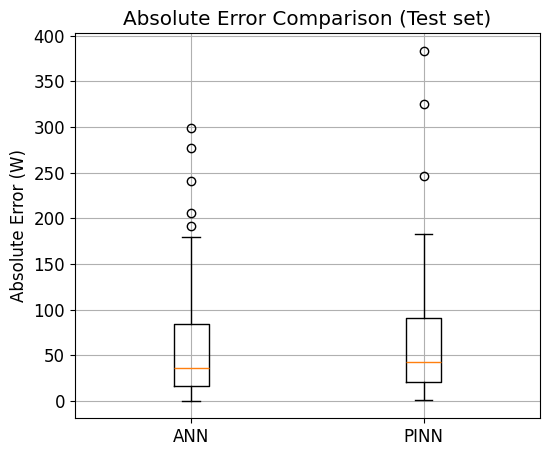

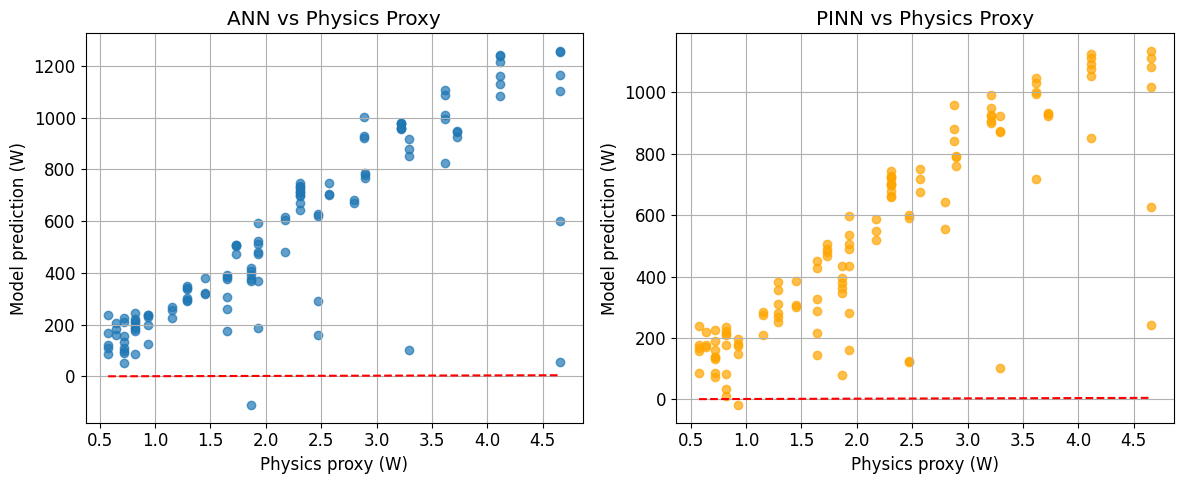

In [ ]:
# Full script: ANN vs PINN
# Uses K_tc=2517.58, K_te=18.9, r=5.0 (mm), phi_j=35 degrees
# =========================

# 0) Install (uncomment in Colab if needed)
# !pip install --upgrade pip
# !pip install chardet xgboost --quiet

# 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# 2) Load data - change path if required
# If the file is in Colab drive use that path instead
file_path = "/mnt/data/Gear_training.csv"   # or "/content/drive/MyDrive/..." if using Drive
if not os.path.exists(file_path):
    # fallback: try common drive path (uncomment if needed)
    file_path = "/content/drive/MyDrive/PINN_DT/GEAR_ML_Basic/Gear_training.csv"

print("Using file:", file_path)
df = pd.read_csv(file_path, encoding="ISO-8859-1")
print("Data rows:", len(df))
print(df.columns.tolist())

# 3) Prepare features / target
# The table you showed uses Feed per flute = 0.1 mm/flute; but dataset columns may be 'Feed Rate' etc.
# We use these columns (adjust if your CSV column names differ)
feature_cols = ["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]
for c in feature_cols + ["P (w)"]:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' not found in CSV. Found columns: {df.columns.tolist()}")

X = df[feature_cols].astype(float).values      # [Fs, a(mm), Ns, T]
y = df["P (w)"].astype(float).values.reshape(-1,1)

# 4) Train-test split + scalers
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler().fit(X_train_raw)
scaler_y = StandardScaler().fit(y_train_raw)

X_train = scaler_X.transform(X_train_raw).astype(np.float32)
X_test = scaler_X.transform(X_test_raw).astype(np.float32)
y_train = scaler_y.transform(y_train_raw).astype(np.float32)
y_test = scaler_y.transform(y_test_raw).astype(np.float32)

# Convert to TF tensors for PINN training
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

# 5) Physics constants (from you)
K_tc = 2517.58   # as provided
K_te = 18.9
r_mm = 5.0       # mm
r_m = r_mm / 1000.0  # convert to meters
phi_deg = 35.0
phi_j = np.deg2rad(phi_deg)

# Physics function using raw (unscaled) inputs (X_raw rows)
def physics_power_from_raw(X_raw_rows):
    """
    X_raw_rows: numpy array shape (n,4)
      columns: [Feed Rate (mm/flute or mm/min?), Depth Of Cut (mm), Spindle Speed (rpm), Time (sec)]
    Returns: P_phys (n,1) in Watts (using consistent units: m, N, rad/s)
    """
    # Interpret column order:
    # Feed per flute (Fs) in mm (user uses Feed Rate column as Fs)
    Fs_mm = X_raw_rows[:, 0].astype(np.float64)
    a_mm = X_raw_rows[:, 1].astype(np.float64)        # depth of cut (mm)
    Ns = X_raw_rows[:, 2].astype(np.float64)          # spindle speed (rpm)

    # convert mm to m where needed
    a_m = a_mm / 1000.0
    Fs_m = Fs_mm / 1000.0

    # chip thickness
    h_phi = Fs_m * np.sin(phi_j)   # m

    # Ft = Ktc * a * h + Kte * a
    # Here K_tc is applied assuming units consistent with a_m and h_phi -> choose K_tc in N/m^2
    Ft = K_tc * a_m * h_phi + K_te * a_m   # N

    # torque tau_s = r * Ft (use r_m in meters)
    tau_s = r_m * Ft   # N·m

    # angular speed
    omega = 2.0 * np.pi * Ns / 60.0  # rad/s

    # spindle power
    P_phy = (tau_s * omega).reshape(-1,1)   # Watts

    return P_phy.astype(np.float32)

# Quick physics sanity check (first 5 train rows)
P_phy_sample = physics_power_from_raw(X_train_raw[:5])
print("Physics proxy sample (W):", P_phy_sample.flatten()[:5])

# 6) Build ANN (data-only)
def build_ann(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

# 7) Build PINN model (same base architecture, tanh activations)
def build_pinn(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(64, activation='tanh'),
        keras.layers.Dense(64, activation='tanh'),
        keras.layers.Dense(1)
    ])
    return model

# 8) Train ANN for same epochs (300)
EPOCHS = 300
BATCH = 32

ann = build_ann(X_train.shape[1])
history_ann = ann.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.1, verbose=0)

# ANN predictions (unscaled)
yhat_ann_scaled = ann.predict(X_test)
yhat_ann = scaler_y.inverse_transform(yhat_ann_scaled)

mse_ann = mean_squared_error(y_test_raw, yhat_ann)
mae_ann = mean_absolute_error(y_test_raw, yhat_ann)
r2_ann = r2_score(y_test_raw, yhat_ann)
print("\nANN test metrics -> MSE: %.3f, MAE: %.3f, R2: %.4f" % (mse_ann, mae_ann, r2_ann))

# 9) Improved PINN training: use physics proxy but scale it to target's scaler_y scale
def train_pinn_with_physics(model, X_train_scaled, X_train_raw, y_train_scaled,
                            lambda_phys=0.02, epochs=EPOCHS, batch_size=BATCH,
                            adaptive_lambda=True, verbose=True):
    """
    model: keras model (uncompiled)
    X_train_scaled: scaled inputs (np.array)
    X_train_raw: raw inputs in original units (np.array) (used for physics)
    y_train_scaled: scaled targets (np.array)
    """
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)

    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    mse = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}
    lam = lambda_phys

    for epoch in range(epochs):
        epoch_data_losses = []
        epoch_phys_losses = []
        epoch_total_losses = []

        for x_scaled_batch, x_raw_batch, y_batch in dataset:
            # x_scaled_batch: scaled inputs (for model). x_raw_batch: raw physical units (for physics)
            with tf.GradientTape() as tape:
                y_pred_scaled = model(x_scaled_batch, training=True)   # predicted in scaled target space

                # data loss (on scaled targets)
                data_loss = mse(y_batch, y_pred_scaled)

                # physics prediction from raw inputs -> returns Watts, we must scale to y-scale
                x_raw_np = x_raw_batch.numpy()
                P_phy = physics_power_from_raw(x_raw_np)              # shape (b,1), in Watts (raw)
                # scale physics proxy to target scaled space
                P_phy_scaled = scaler_y.transform(P_phy)              # numpy array
                P_phy_scaled_tf = tf.convert_to_tensor(P_phy_scaled, dtype=tf.float32)

                # physics loss (on scaled space)
                phys_loss = tf.reduce_mean(tf.square(y_pred_scaled - P_phy_scaled_tf))

                total_loss = data_loss + lam * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            epoch_data_losses.append(data_loss.numpy())
            epoch_phys_losses.append(phys_loss.numpy())
            epoch_total_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(epoch_data_losses))
        history["phys_loss"].append(np.mean(epoch_phys_losses))
        history["total_loss"].append(np.mean(epoch_total_losses))

        # adaptive lambda to avoid physics dominating early or late
        if adaptive_lambda and ((epoch+1) % 50 == 0):
            lam *= 0.7

        if verbose and ((epoch+1) % 25 == 0 or epoch==0 or epoch==epochs-1):
            print(f"Epoch {epoch+1}/{epochs} -> data_loss={history['data_loss'][-1]:.6f}, "
                  f"phys_loss={history['phys_loss'][-1]:.6f}, total={history['total_loss'][-1]:.6f}, lam={lam:.5f}")

    return model, history

# instantiate PINN
pinn = build_pinn(X_train.shape[1])
pinn, history_pinn = train_pinn_with_physics(pinn, X_train, X_train_raw, y_train,
                                             lambda_phys=0.02, epochs=EPOCHS, batch_size=BATCH,
                                             adaptive_lambda=True, verbose=True)

# 10) PINN predictions (reverse scaling)
yhat_pinn_scaled = pinn.predict(X_test)
yhat_pinn = scaler_y.inverse_transform(yhat_pinn_scaled)

mse_pinn = mean_squared_error(y_test_raw, yhat_pinn)
mae_pinn = mean_absolute_error(y_test_raw, yhat_pinn)
r2_pinn = r2_score(y_test_raw, yhat_pinn)
print("\nPINN test metrics -> MSE: %.3f, MAE: %.3f, R2: %.4f" % (mse_pinn, mae_pinn, r2_pinn))

# 11) Plots: loss curves, pred vs true, residuals, physics-consistency, extrapolation test
plt.rcParams.update({'font.size':12})

# Loss curves (ANN training loss + PINN three losses)
plt.figure(figsize=(12,5))
plt.plot(history_ann.history['loss'], label='ANN Train Loss')
if 'val_loss' in history_ann.history:
    plt.plot(history_ann.history['val_loss'], label='ANN Val Loss', linestyle='--')
plt.plot(history_pinn['total_loss'], label='PINN Total Loss')
plt.plot(history_pinn['data_loss'], label='PINN Data Loss', linestyle=':')
plt.plot(history_pinn['phys_loss'], label='PINN Physics Loss', linestyle='-.')
plt.xlabel('Epoch'); plt.ylabel('Loss (MSE scaled)'); plt.title('Training Losses'); plt.legend(); plt.grid()
plt.show()

# Predictions vs True
plt.figure(figsize=(10,6))
plt.scatter(y_test_raw, yhat_ann, label=f'ANN (R2={r2_ann:.3f})', alpha=0.7, s=25)
plt.scatter(y_test_raw, yhat_pinn, label=f'PINN (R2={r2_pinn:.3f})', alpha=0.7, s=25)
mn = min(y_test_raw.min(), yhat_ann.min(), yhat_pinn.min()); mx = max(y_test_raw.max(), yhat_ann.max(), yhat_pinn.max())
plt.plot([mn,mx],[mn,mx],'k--', linewidth=1)
plt.xlabel('True Power (W)'); plt.ylabel('Predicted Power (W)')
plt.title('Predicted vs True: ANN vs PINN'); plt.legend(); plt.grid()
plt.show()

# Residual histograms
res_ann = (y_test_raw - yhat_ann).flatten()
res_pinn = (y_test_raw - yhat_pinn).flatten()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(res_ann, bins=25, alpha=0.7, label='ANN')
plt.xlabel('Residual (True - Pred) [W]'); plt.title('ANN Residuals'); plt.grid(True)
plt.subplot(1,2,2)
plt.hist(res_pinn, bins=25, alpha=0.7, color='orange', label='PINN')
plt.xlabel('Residual (True - Pred) [W]'); plt.title('PINN Residuals'); plt.grid(True)
plt.tight_layout(); plt.show()

# Boxplot of absolute errors
abs_ann = np.abs(res_ann); abs_pinn = np.abs(res_pinn)
plt.figure(figsize=(6,5))
plt.boxplot([abs_ann, abs_pinn], labels=['ANN', 'PINN'])
plt.ylabel('Absolute Error (W)')
plt.title('Absolute Error Comparison (Test set)')
plt.grid(True); plt.show()

# Physics-consistency scatter: model predictions vs physics proxy computed on test set raw
P_phys_test = physics_power_from_raw(X_test_raw)        # Watts
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(P_phys_test, yhat_ann, alpha=0.7, label='ANN preds')
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel('Physics proxy (W)'); plt.ylabel('Model prediction (W)')
plt.title('ANN vs Physics Proxy'); plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(P_phys_test, yhat_pinn, alpha=0.7, label='PINN preds', color='orange')
plt.plot([P_phys_test.min(), P_phys_test.max()], [P_phys_test.min(), P_phys_test.max()], 'r--')
plt.xlabel('Physics proxy (W)'); plt.ylabel('Model prediction (W)')
plt.title('PINN vs Physics Proxy'); plt.grid(True)
plt.tight_layout(); plt.show()

# Extrapolation test: increase spindle speed by 50% for test set and compare
X_extrap = X_test_raw.copy()
X_extrap[:,2] = X_extrap[:,2] * 1.5   # increase s*


In [ ]:
from tensorflow.keras import layers


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers   # <-- add this
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
# ANN vs 3 PINNs
# =========================

# (Keep your imports, data loading, scalers, physics_power_from_raw from earlier!)

# -------------------------
# Method 1: Soft Constraint PINN
# -------------------------
def train_pinn_soft(model, X_train_scaled, X_train_raw, y_train_scaled,
                    lambda_phys=0.02, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)

    optimizer = keras.optimizers.Adam(1e-3)
    mse = keras.losses.MeanSquaredError()
    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        batch_data_losses, batch_phys_losses, batch_total_losses = [], [], []

        for x_scaled, x_raw, y_true in dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x_scaled, training=True)
                data_loss = mse(y_true, y_pred)

                P_phys = physics_power_from_raw(x_raw.numpy())
                P_phys_scaled = scaler_y.transform(P_phys)
                P_phys_tf = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = tf.reduce_mean(tf.square(y_pred - P_phys_tf))
                total_loss = data_loss + lambda_phys * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            batch_data_losses.append(data_loss.numpy())
            batch_phys_losses.append(phys_loss.numpy())
            batch_total_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(batch_data_losses))
        history["phys_loss"].append(np.mean(batch_phys_losses))
        history["total_loss"].append(np.mean(batch_total_losses))

    return model, history


# -------------------------
# Method 2: Hybrid PINN (multi-task)
# -------------------------
def build_pinn_hybrid(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="tanh")(inputs)
    x = layers.Dense(64, activation="tanh")(x)
    out_data = layers.Dense(1, name="data_output")(x)
    out_phys = layers.Dense(1, name="phys_output")(x)
    model = keras.Model(inputs=inputs, outputs=[out_data, out_phys])
    return model

def train_pinn_hybrid(model, X_train_scaled, X_train_raw, y_train_scaled, epochs=300, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, X_train_raw, y_train_scaled))
    dataset = dataset.shuffle(buffer_size=len(X_train_scaled)).batch(batch_size)
    optimizer = keras.optimizers.Adam(1e-3)
    mse = keras.losses.MeanSquaredError()

    history = {"data_loss": [], "phys_loss": [], "total_loss": []}

    for epoch in range(epochs):
        d_losses, p_losses, t_losses = [], [], []
        for x_scaled, x_raw, y_true in dataset:
            with tf.GradientTape() as tape:
                y_data, y_phys = model(x_scaled, training=True)

                data_loss = mse(y_true, y_data)

                P_phys = physics_power_from_raw(x_raw.numpy())
                P_phys_scaled = scaler_y.transform(P_phys)
                P_phys_tf = tf.convert_to_tensor(P_phys_scaled, dtype=tf.float32)

                phys_loss = mse(P_phys_tf, y_phys)

                total_loss = data_loss + 0.5 * phys_loss

            grads = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            d_losses.append(data_loss.numpy())
            p_losses.append(phys_loss.numpy())
            t_losses.append(total_loss.numpy())

        history["data_loss"].append(np.mean(d_losses))
        history["phys_loss"].append(np.mean(p_losses))
        history["total_loss"].append(np.mean(t_losses))

    return model, history


# -------------------------
# Method 3: Physics-Guided Feature PINN
# -------------------------
def add_physics_feature(X_raw, X_scaled):
    P_phys = physics_power_from_raw(X_raw)
    P_phys_scaled = scaler_y.transform(P_phys)
    return np.hstack([X_scaled, P_phys_scaled])

X_train_pg = add_physics_feature(X_train_raw, X_train)
X_test_pg = add_physics_feature(X_test_raw, X_test)

def build_pinn_pg(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="tanh"),
        layers.Dense(64, activation="tanh"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model


# -------------------------
# Train all models
# -------------------------
# ANN
ann = build_ann(X_train.shape[1])
ann.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0)

# PINN 1 (Soft constraint)
pinn_soft = build_pinn(X_train.shape[1])
pinn_soft, hist_soft = train_pinn_soft(pinn_soft, X_train, X_train_raw, y_train, epochs=300)

# PINN 2 (Hybrid)
pinn_hybrid = build_pinn_hybrid(X_train.shape[1])
pinn_hybrid, hist_hybrid = train_pinn_hybrid(pinn_hybrid, X_train, X_train_raw, y_train, epochs=300)

# PINN 3 (Physics-guided feature)
pinn_pg = build_pinn_pg(X_train_pg.shape[1])
pinn_pg.fit(X_train_pg, y_train, epochs=300, batch_size=32, verbose=0)

# -------------------------
# Evaluate all models
# -------------------------
def evaluate_model(model, X_scaled, X_raw, y_true, type="ann"):
    if type == "pg":
        X_in = add_physics_feature(X_raw, X_scaled)
        yhat_scaled = model.predict(X_in)
    elif type == "hybrid":
        yhat_scaled, _ = model.predict(X_scaled)
    else:
        yhat_scaled = model.predict(X_scaled)

    yhat = scaler_y.inverse_transform(yhat_scaled)
    mse = mean_squared_error(y_true, yhat)
    mae = mean_absolute_error(y_true, yhat)
    r2 = r2_score(y_true, yhat)
    return mse, mae, r2

results = {
    "ANN": evaluate_model(ann, X_test, X_test_raw, y_test_raw, "ann"),
    "PINN_Soft": evaluate_model(pinn_soft, X_test, X_test_raw, y_test_raw, "soft"),
    "PINN_Hybrid": evaluate_model(pinn_hybrid, X_test, X_test_raw, y_test_raw, "hybrid"),
    "PINN_Feature": evaluate_model(pinn_pg, X_test, X_test_raw, y_test_raw, "pg"),
}

print("\nModel Comparison (MSE, MAE, R2):")
for k,v in results.items():
    print(f"{k}: MSE={v[0]:.2f}, MAE={v[1]:.2f}, R2={v[2]:.3f}")

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Model Comparison (MSE, MAE, R2):
ANN: MSE=6632.86, MAE=64.98, R2=0.947
PINN_Soft: MSE=8184.51, MAE=62.78, R2=0.935
PINN_Hybrid: MSE=9128.25, MAE=67.18, R2=0.928
PINN_Feature: MSE=7346.81, MAE=57.93, R2=0.942


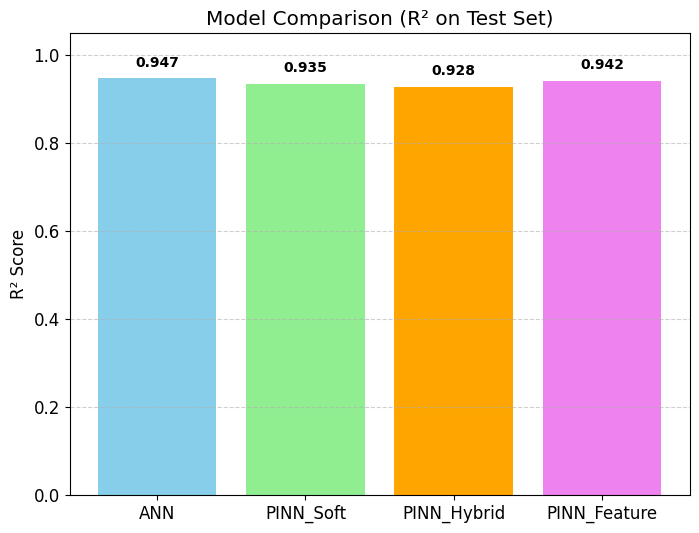

In [ ]:
# ============================
# R² Score Comparison Plot
# ============================
model_names = list(results.keys())
r2_scores = [v[2] for v in results.values()]  # R2 is the 3rd element in tuple

plt.figure(figsize=(8,6))
bars = plt.bar(model_names, r2_scores, color=["skyblue","lightgreen","orange","violet"])
plt.ylim(0, 1.05)
plt.ylabel("R² Score")
plt.title("Model Comparison (R² on Test Set)")

# Annotate bars with R² values
for bar, r2 in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02,
             f"{r2:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


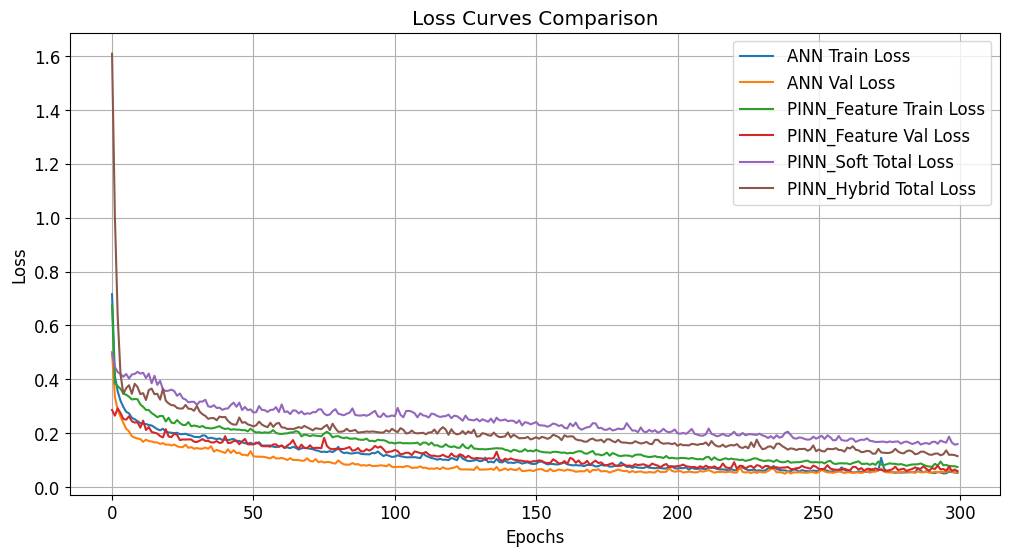

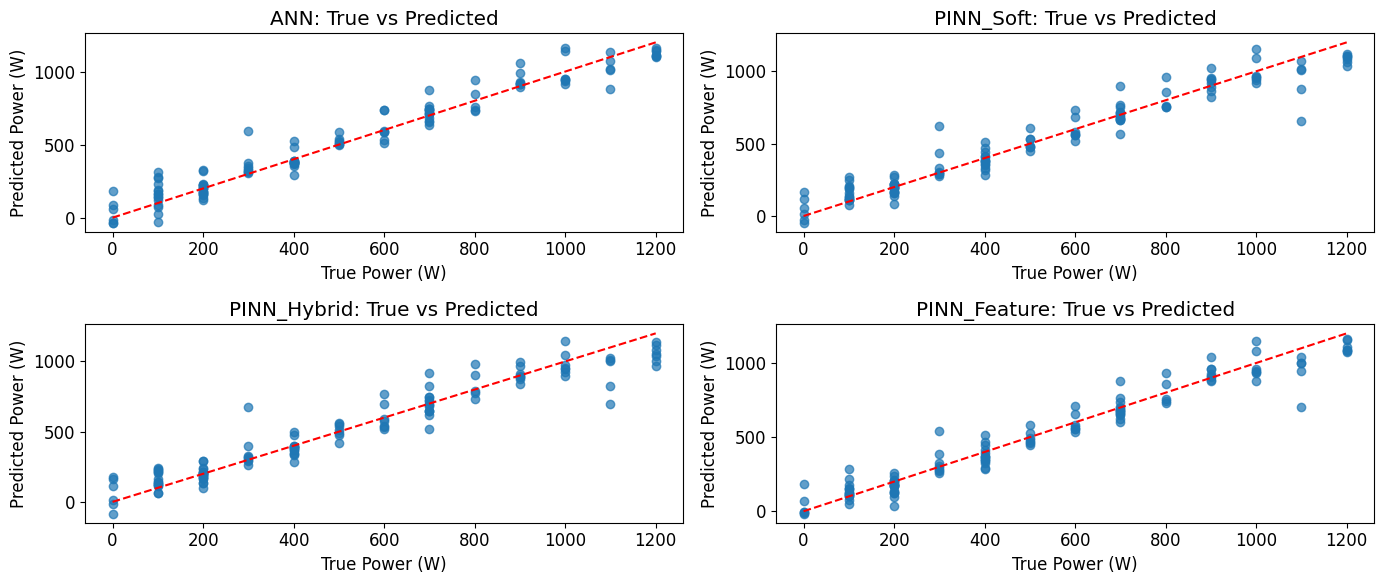

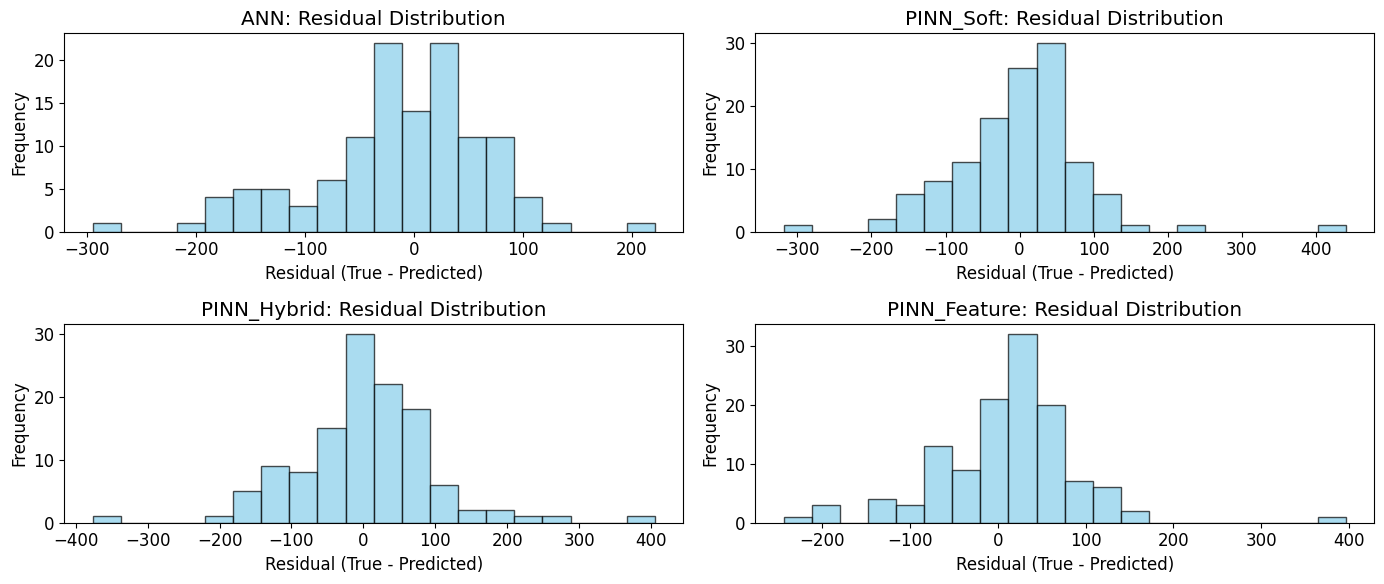

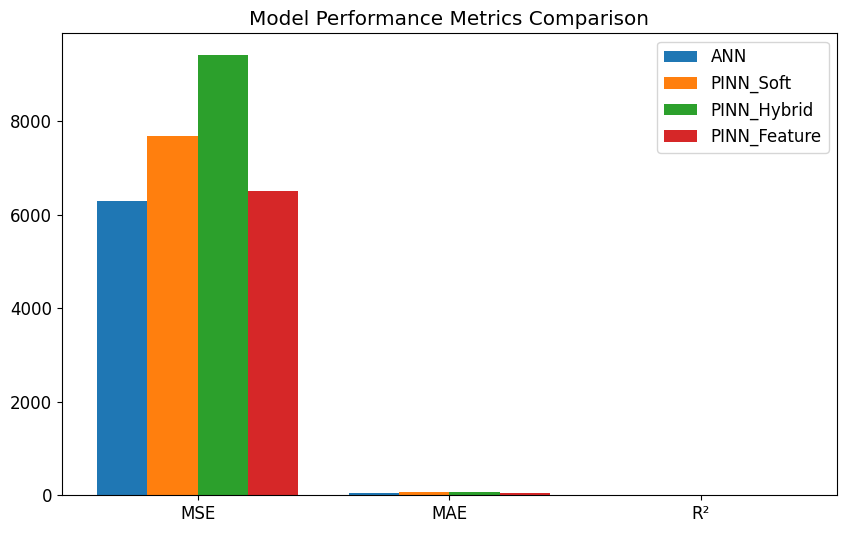


Model Comparison (MSE, MAE, R2):
ANN: MSE=6279.98, MAE=59.08, R2=0.950
PINN_Soft: MSE=7669.70, MAE=61.27, R2=0.939
PINN_Hybrid: MSE=9403.23, MAE=67.86, R2=0.925
PINN_Feature: MSE=6511.17, MAE=58.78, R2=0.948


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------
# Functions (use from previous code for ANN, PINN Soft, PINN Hybrid, PINN Feature)
# -------------------------

def evaluate_model(model, X_scaled, X_raw, y_true, scaler_y, type="ann"):
    """Evaluate model on test data"""
    if type == "pg":
        X_in = add_physics_feature(X_raw, X_scaled)
        yhat_scaled = model.predict(X_in)
    elif type == "hybrid":
        yhat_scaled, _ = model.predict(X_scaled)
    else:
        yhat_scaled = model.predict(X_scaled)

    yhat = scaler_y.inverse_transform(yhat_scaled)
    mse = mean_squared_error(y_true, yhat)
    mae = mean_absolute_error(y_true, yhat)
    r2 = r2_score(y_true, yhat)
    return mse, mae, r2, yhat

# -------------------------
# Train all models
# -------------------------

# ANN
ann = build_ann(X_train.shape[1])
hist_ann = ann.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0, validation_data=(X_test, y_test))

# PINN 1: Soft
pinn_soft = build_pinn(X_train.shape[1])
pinn_soft, hist_soft = train_pinn_soft(pinn_soft, X_train, X_train_raw, y_train, epochs=300)

# PINN 2: Hybrid
pinn_hybrid = build_pinn_hybrid(X_train.shape[1])
pinn_hybrid, hist_hybrid = train_pinn_hybrid(pinn_hybrid, X_train, X_train_raw, y_train, epochs=300)

# PINN 3: Physics-guided feature
pinn_pg = build_pinn_pg(X_train_pg.shape[1])
hist_pg = pinn_pg.fit(X_train_pg, y_train, epochs=300, batch_size=32, verbose=0, validation_data=(X_test_pg, y_test))

# -------------------------
# Evaluate all models
# -------------------------
results = {}
predictions = {}

results["ANN"], predictions["ANN"] = evaluate_model(ann, X_test, X_test_raw, y_test_raw, scaler_y, "ann")[:3], evaluate_model(ann, X_test, X_test_raw, y_test_raw, scaler_y, "ann")[3]
results["PINN_Soft"], predictions["PINN_Soft"] = evaluate_model(pinn_soft, X_test, X_test_raw, y_test_raw, scaler_y, "soft")[:3], evaluate_model(pinn_soft, X_test, X_test_raw, y_test_raw, scaler_y, "soft")[3]
results["PINN_Hybrid"], predictions["PINN_Hybrid"] = evaluate_model(pinn_hybrid, X_test, X_test_raw, y_test_raw, scaler_y, "hybrid")[:3], evaluate_model(pinn_hybrid, X_test, X_test_raw, y_test_raw, scaler_y, "hybrid")[3]
results["PINN_Feature"], predictions["PINN_Feature"] = evaluate_model(pinn_pg, X_test, X_test_raw, y_test_raw, scaler_y, "pg")[:3], evaluate_model(pinn_pg, X_test, X_test_raw, y_test_raw, scaler_y, "pg")[3]

# -------------------------
# 📊 Plots
# -------------------------

# 1. Loss Curves
plt.figure(figsize=(12,6))
plt.plot(hist_ann.history['loss'], label="ANN Train Loss")
plt.plot(hist_ann.history['val_loss'], label="ANN Val Loss")
plt.plot(hist_pg.history['loss'], label="PINN_Feature Train Loss")
plt.plot(hist_pg.history['val_loss'], label="PINN_Feature Val Loss")
plt.plot(hist_soft['total_loss'], label="PINN_Soft Total Loss")
plt.plot(hist_hybrid['total_loss'], label="PINN_Hybrid Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()

# 2. True vs Predicted
plt.figure(figsize=(14,6))
for i, model in enumerate(results.keys()):
    plt.subplot(2,2,i+1)
    plt.scatter(y_test_raw, predictions[model], alpha=0.7)
    plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'r--')
    plt.title(f"{model}: True vs Predicted")
    plt.xlabel("True Power (W)")
    plt.ylabel("Predicted Power (W)")
plt.tight_layout()
plt.show()

# 3. Residuals
plt.figure(figsize=(14,6))
for i, model in enumerate(results.keys()):
    plt.subplot(2,2,i+1)
    residuals = y_test_raw.flatten() - predictions[model].flatten()
    plt.hist(residuals, bins=20, alpha=0.7, color="skyblue", edgecolor="black")
    plt.title(f"{model}: Residual Distribution")
    plt.xlabel("Residual (True - Predicted)")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 4. Metrics Bar Chart
metrics = ["MSE", "MAE", "R²"]
x = np.arange(len(metrics))
bar_width = 0.2

plt.figure(figsize=(10,6))
for i, (model, vals) in enumerate(results.items()):
    plt.bar(x + i*bar_width, vals, width=bar_width, label=model)

plt.xticks(x + bar_width*1.5, metrics)
plt.title("Model Performance Metrics Comparison")
plt.legend()
plt.show()

# -------------------------
# Print Results
# -------------------------
print("\nModel Comparison (MSE, MAE, R2):")
for model, vals in results.items():
    print(f"{model}: MSE={vals[0]:.2f}, MAE={vals[1]:.2f}, R2={vals[2]:.3f}")



🔹 SHAP for ANN


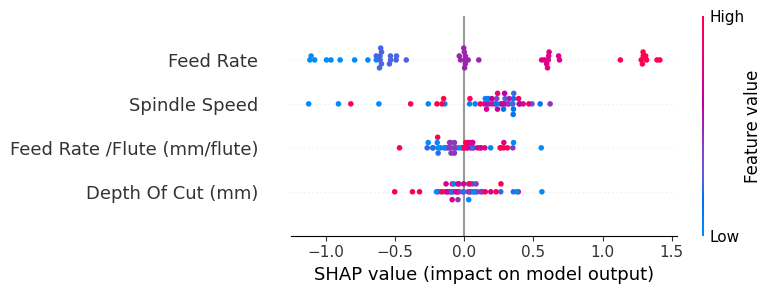

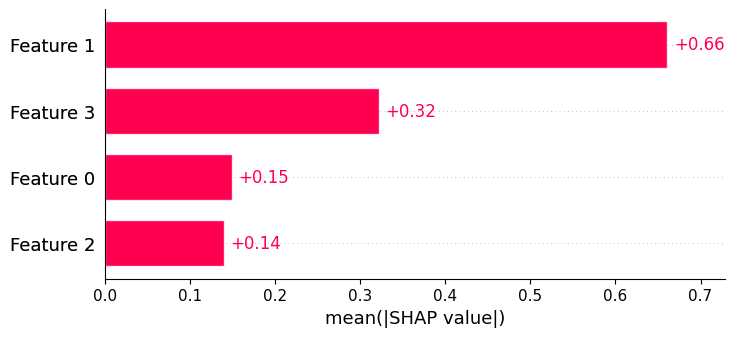


🔹 SHAP for PINN (Soft Constraint)


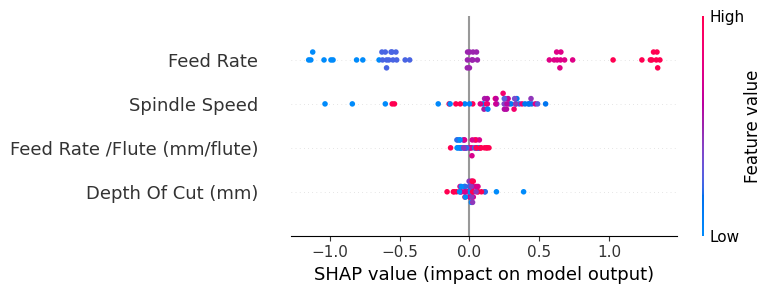

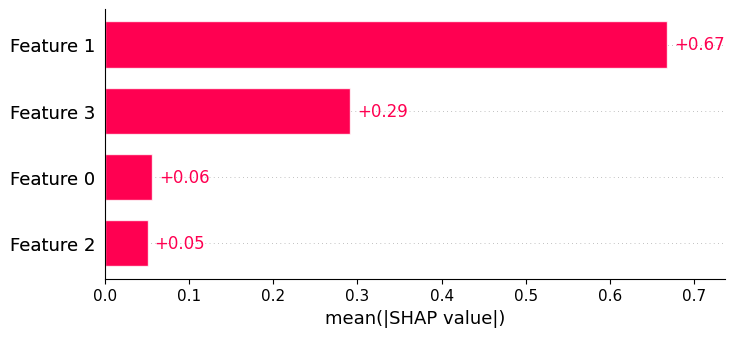


🔹 SHAP for PINN (Hybrid)


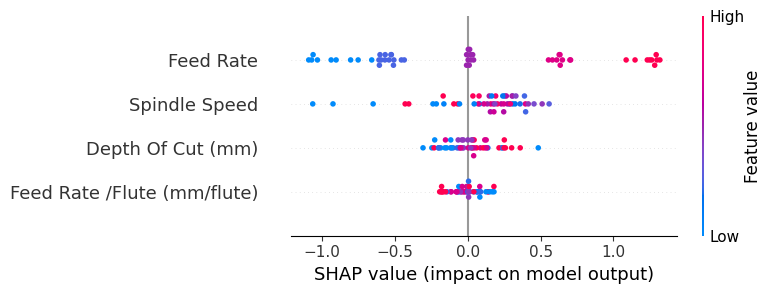

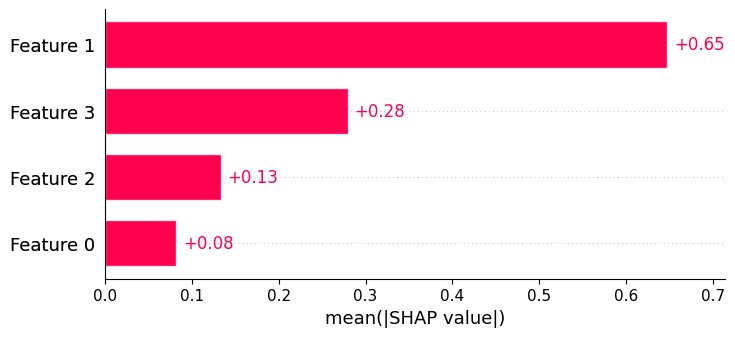


🔹 SHAP for PINN (Physics-Guided Features)


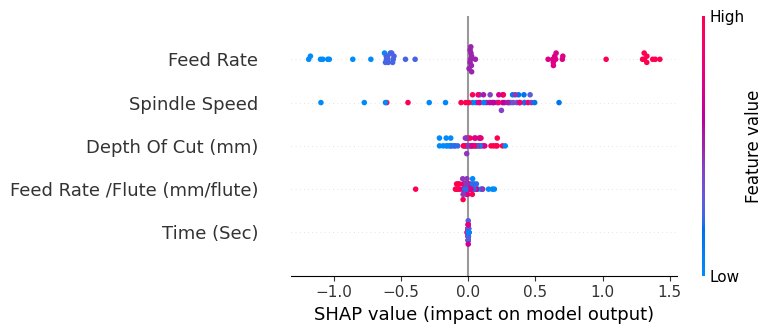

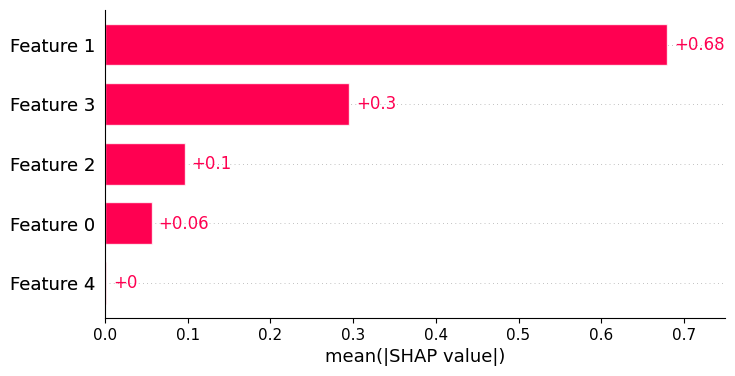

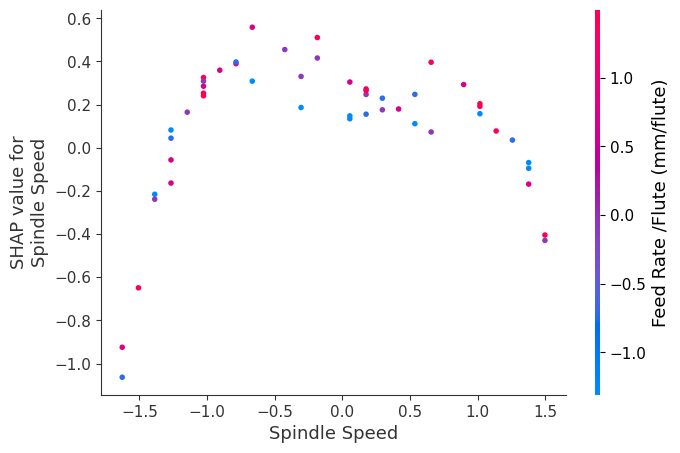

In [ ]:
# ======================
# SHAP Explainability for All Models
# ======================
import shap
import matplotlib.pyplot as plt

# pick a smaller background dataset for speed
background = X_train[:200]
test_samples = X_test[:50]

# feature names
feature_names = [c for c in df.columns if c != "Power"]

# ----------------
# ANN
# ----------------
print("\n🔹 SHAP for ANN")
explainer_ann = shap.Explainer(ann, background)
shap_values_ann = explainer_ann(test_samples)

shap.summary_plot(shap_values_ann, test_samples, feature_names=feature_names, show=True)
shap.plots.bar(shap_values_ann, max_display=len(feature_names), show=True)

# ----------------
# PINN Soft
# ----------------
print("\n🔹 SHAP for PINN (Soft Constraint)")
explainer_soft = shap.Explainer(pinn_soft, background)
shap_values_soft = explainer_soft(test_samples)

shap.summary_plot(shap_values_soft, test_samples, feature_names=feature_names, show=True)
shap.plots.bar(shap_values_soft, max_display=len(feature_names), show=True)

# ----------------
# PINN Hybrid (explain only data-output head)
# ----------------
print("\n🔹 SHAP for PINN (Hybrid)")
def hybrid_predict(X):
    y_data, _ = pinn_hybrid(X)
    return y_data

explainer_hybrid = shap.Explainer(hybrid_predict, background)
shap_values_hybrid = explainer_hybrid(test_samples)

shap.summary_plot(shap_values_hybrid, test_samples, feature_names=feature_names, show=True)
shap.plots.bar(shap_values_hybrid, max_display=len(feature_names), show=True)

# ----------------
# PINN Feature (extra physics feature)
# ----------------
print("\n🔹 SHAP for PINN (Physics-Guided Features)")
background_pg = add_physics_feature(X_train_raw[:200], X_train[:200])
test_samples_pg = add_physics_feature(X_test_raw[:50], X_test[:50])

feature_names_pg = feature_names + ["Physics_Power"]

explainer_pg = shap.Explainer(pinn_pg, background_pg)
shap_values_pg = explainer_pg(test_samples_pg)

shap.summary_plot(shap_values_pg, test_samples_pg, feature_names=feature_names_pg, show=True)
shap.plots.bar(shap_values_pg, max_display=len(feature_names_pg), show=True)

# ----------------
# Example dependence plot (Spindle Speed influence on Hybrid PINN)
# ----------------
shap.dependence_plot("Spindle Speed", shap_values_hybrid.values, test_samples,
                     feature_names=feature_names, show=True)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/tmp/ipython-input-2570444830.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


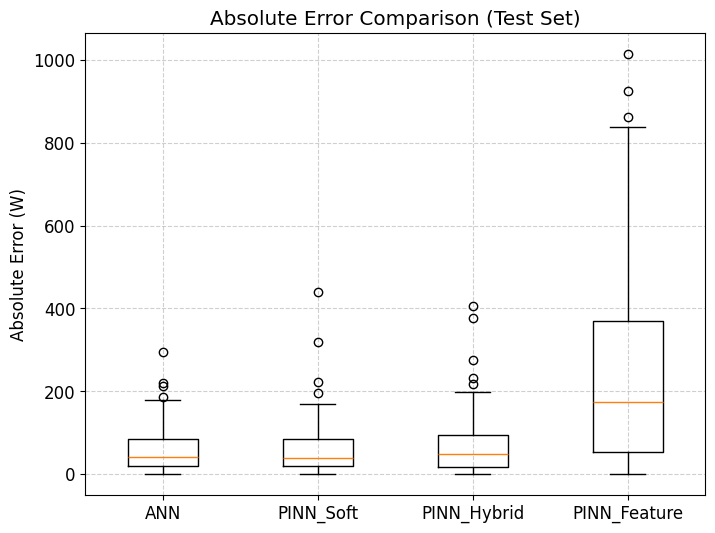

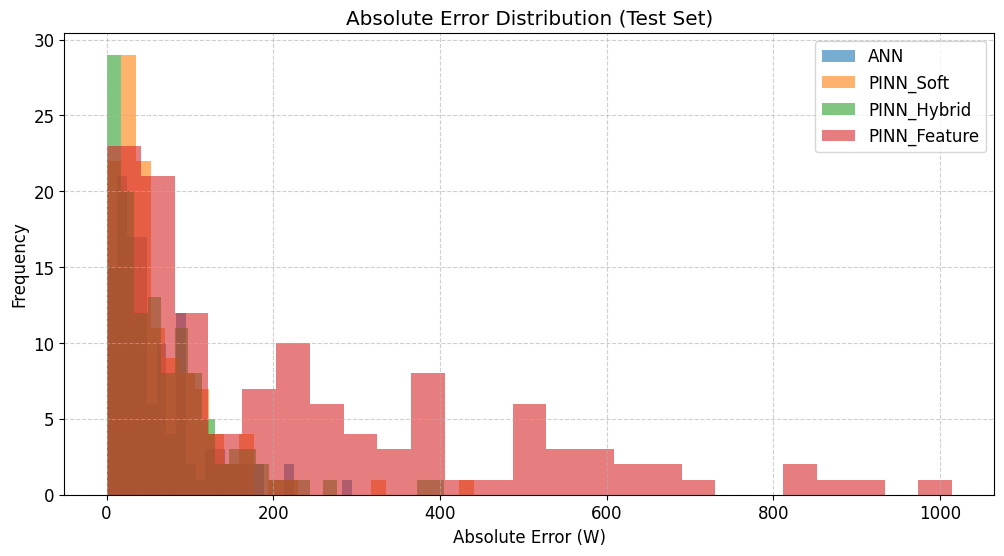

In [ ]:
# ============================
# Absolute Error Comparison
# ============================
def get_predictions(model, X_scaled, X_raw, type="ann"):
    """Helper to get inverse-scaled predictions."""
    if type == "pg":
        X_in = add_physics_feature(X_raw, X_scaled)
        yhat_scaled = model.predict(X_in)
    elif type == "hybrid":
        yhat_scaled, _ = model.predict(X_scaled)
    else:
        yhat_scaled = model.predict(X_scaled)

    return scaler_y.inverse_transform(yhat_scaled)

# Predictions for each model
yhat_ann = get_predictions(ann, X_test, X_test_raw, "ann")
yhat_soft = get_predictions(pinn_soft, X_test, X_test_raw, "soft")
yhat_hybrid = get_predictions(pinn_hybrid, X_test, X_test_raw, "hybrid")
yhat_pg = get_predictions(pinn_pg, X_test, X_test_raw, "pg")

# Residuals (absolute error)
abs_err_ann = np.abs(y_test_raw.flatten() - yhat_ann.flatten())
abs_err_soft = np.abs(y_test_raw.flatten() - yhat_soft.flatten())
abs_err_hybrid = np.abs(y_test_raw.flatten() - yhat_hybrid.flatten())
abs_err_pg = np.abs(y_test_raw.flatten() - yhat_pg.flatten())

# -----------------------------
# 📊 Boxplot of absolute errors
# -----------------------------
plt.figure(figsize=(8,6))
plt.boxplot(
    [abs_err_ann, abs_err_soft, abs_err_hybrid, abs_err_pg],
    labels=["ANN", "PINN_Soft", "PINN_Hybrid", "PINN_Feature"]
)
plt.ylabel("Absolute Error (W)")
plt.title("Absolute Error Comparison (Test Set)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# -----------------------------
# 📊 Histogram of absolute errors
# -----------------------------
plt.figure(figsize=(12,6))
plt.hist(abs_err_ann, bins=25, alpha=0.6, label="ANN")
plt.hist(abs_err_soft, bins=25, alpha=0.6, label="PINN_Soft")
plt.hist(abs_err_hybrid, bins=25, alpha=0.6, label="PINN_Hybrid")
plt.hist(abs_err_pg, bins=25, alpha=0.6, label="PINN_Feature")
plt.xlabel("Absolute Error (W)")
plt.ylabel("Frequency")
plt.title("Absolute Error Distribution (Test Set)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
    Time (Sec)  Actual P (w)  Predicted P (w)
0            0           400       460.774445
1            1           700       611.759521
2            2           700       754.270508
3            3           700       841.767822
4            4           800       860.036072
5            5           800       831.830811
6            6           700       792.360352
7            7           700       757.789062
8            8           600       730.409729
9            9           700       710.074158
10          10           700       696.117859
11          11           700       687.292786
12          12           700       682.082214
13          13           700       679.025818
14          14           700       676.939514
15          15           500       675.071899
16          16           700       673.180054
17          17           600       671.492310
18          18           700       670.554321
19          19           700       670.989

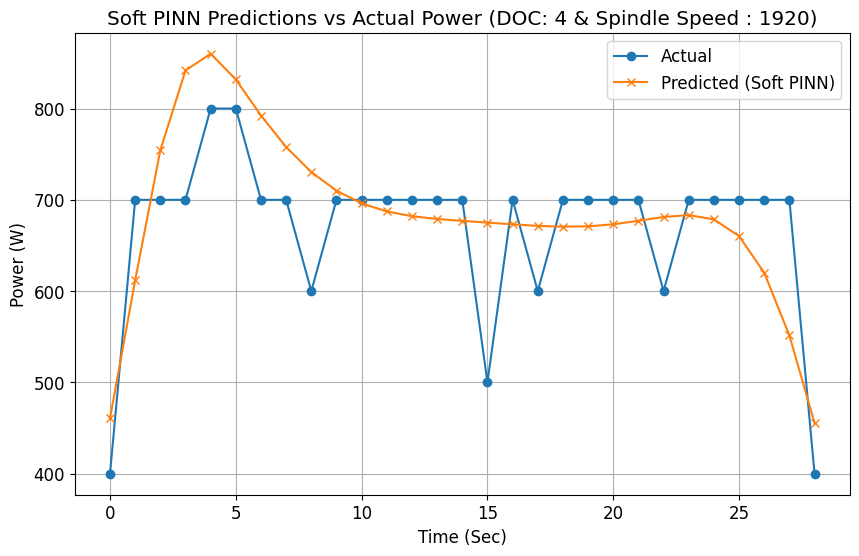

In [ ]:
# ======================
# New Test Data (Fixed)
# ======================
data_dict = {
    "Feed Rate /Flute (mm/flute)": [0.1]*29,
    "Feed Rate": [384]*29,
    "Depth Of Cut (mm)": [4]*29,
    "Spindle Speed": [1920]*29,
    "Time (Sec)": list(range(0, 29)),  # 0 → 28 (29 values)
    "Actual P (w)": [
        400,700,700,700,800,800,700,700,600,700,
        700,700,700,700,700,500,700,600,700,700,
        700,700,600,700,700,700,700,700,400
    ]
}

df_new = pd.DataFrame(data_dict)

# Separate features and target
X_new_raw = df_new[["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]].values
y_new_actual = df_new["Actual P (w)"].values.reshape(-1,1)

# Scale features
X_new_scaled = scaler_X.transform(X_new_raw)

# ======================
# Predict with Reloaded Soft PINN
# ======================
y_new_pred_scaled = pinn_soft_loaded.predict(X_new_scaled)
y_new_pred = scaler_y.inverse_transform(y_new_pred_scaled)

# ======================
# Compare Predictions
# ======================
results_df = pd.DataFrame({
    "Time (Sec)": df_new["Time (Sec)"],
    "Actual P (w)": y_new_actual.flatten(),
    "Predicted P (w)": y_new_pred.flatten()
})

print(results_df)

# ======================
# Plot Actual vs Predicted
# ======================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(results_df["Time (Sec)"], results_df["Actual P (w)"], label="Actual", marker="o")
plt.plot(results_df["Time (Sec)"], results_df["Predicted P (w)"], label="Predicted (Soft PINN)", marker="x")
plt.xlabel("Time (Sec)")
plt.ylabel("Power (W)")
plt.title("Soft PINN Predictions vs Actual Power (DOC: 4 & Spindle Speed : 1920)")
plt.legend()
plt.grid(True)
plt.show()


✅ Hybrid PINN model saved!
✅ Hybrid PINN model loaded!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
📊 Standard Deviation of Prediction Error (Hybrid PINN): 72.24 W


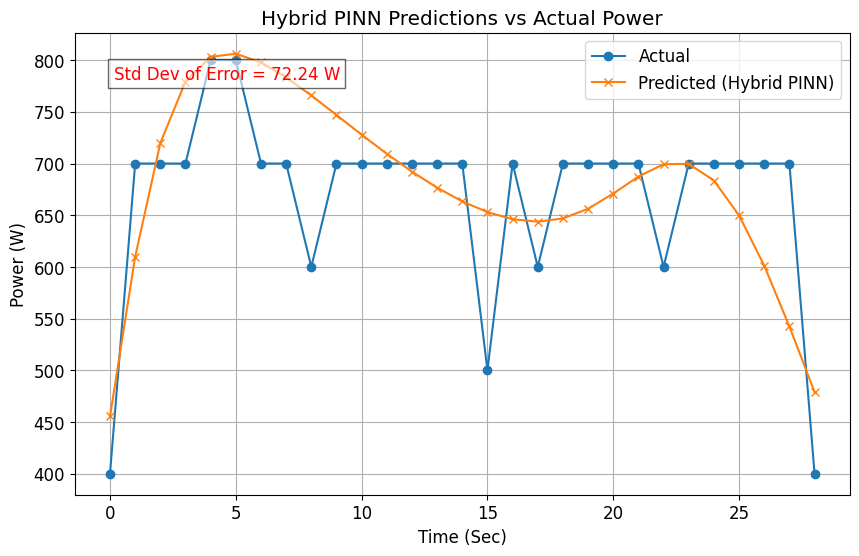

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ======================
# Save Hybrid PINN model
# ======================
pinn_hybrid.save("pinn_hybrid_model.keras")
print("✅ Hybrid PINN model saved!")

# ======================
# Load Hybrid PINN model
# ======================
pinn_hybrid_loaded = keras.models.load_model("pinn_hybrid_model.keras")
print("✅ Hybrid PINN model loaded!")

# ======================
# Predict with Hybrid PINN (use only data_output)
# ======================
y_new_pred_scaled, _ = pinn_hybrid_loaded.predict(X_new_scaled)  # two outputs
y_new_pred = scaler_y.inverse_transform(y_new_pred_scaled)

# ======================
# Compare with Actual
# ======================
results_hybrid = pd.DataFrame({
    "Time (Sec)": df_new["Time (Sec)"],
    "Actual P (w)": y_new_actual.flatten(),
    "Predicted P (w) (Hybrid PINN)": y_new_pred.flatten()
})

# ======================
# Calculate Standard Deviation of Error
# ======================
errors = results_hybrid["Actual P (w)"] - results_hybrid["Predicted P (w) (Hybrid PINN)"]
std_error = np.std(errors)

print(f"📊 Standard Deviation of Prediction Error (Hybrid PINN): {std_error:.2f} W")

# ======================
# Plot Actual vs Predicted with StdDev annotation
# ======================
plt.figure(figsize=(10,6))
plt.plot(results_hybrid["Time (Sec)"], results_hybrid["Actual P (w)"], label="Actual", marker="o")
plt.plot(results_hybrid["Time (Sec)"], results_hybrid["Predicted P (w) (Hybrid PINN)"],
         label="Predicted (Hybrid PINN)", marker="x")

plt.xlabel("Time (Sec)")
plt.ylabel("Power (W)")
plt.title("Hybrid PINN Predictions vs Actual Power")

# Annotate std deviation
plt.text(
    0.05, 0.9, f"Std Dev of Error = {std_error:.2f} W",
    transform=plt.gca().transAxes,
    fontsize=12, color="red", bbox=dict(facecolor="white", alpha=0.6)
)

plt.legend()
plt.grid(True)
plt.show()


✅ Hybrid PINN model saved!
✅ Hybrid PINN model loaded!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
   Time (Sec)  Actual P (w)  Predicted P (w) (Hybrid PINN)
0           0           400                     455.344055
1           1           700                     609.823975
2           2           700                     719.747009
3           3           700                     779.265015
4           4           800                     803.142151


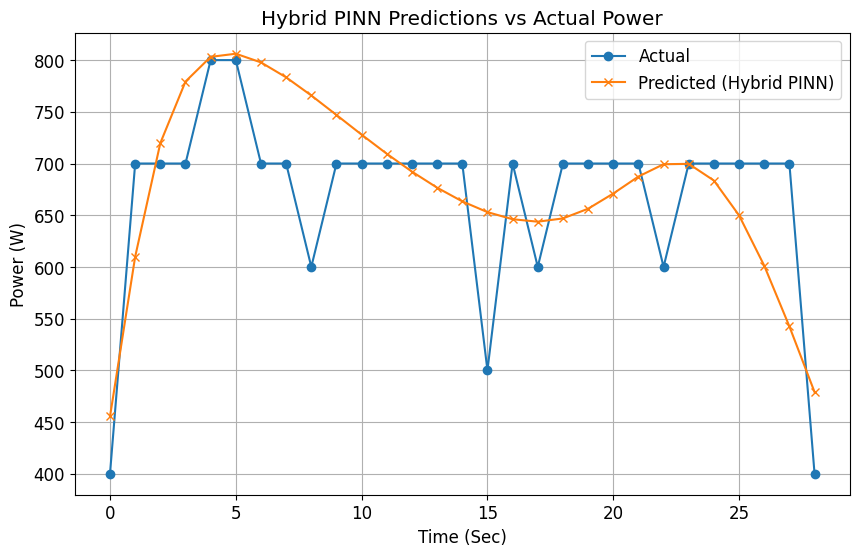

In [ ]:
# ======================
# Save Hybrid PINN model
# ======================
pinn_hybrid.save("pinn_hybrid_model.keras")
print("✅ Hybrid PINN model saved!")

# ======================
# Load Hybrid PINN model
# ======================
pinn_hybrid_loaded = keras.models.load_model("pinn_hybrid_model.keras")
print("✅ Hybrid PINN model loaded!")

# ======================
# Predict with Hybrid PINN (use only data_output)
# ======================
y_new_pred_scaled, _ = pinn_hybrid_loaded.predict(X_new_scaled)  # two outputs
y_new_pred = scaler_y.inverse_transform(y_new_pred_scaled)

# ======================
# Compare with Actual
# ======================
results_hybrid = pd.DataFrame({
    "Time (Sec)": df_new["Time (Sec)"],
    "Actual P (w)": y_new_actual.flatten(),
    "Predicted P (w) (Hybrid PINN)": y_new_pred.flatten()
})

print(results_hybrid.head())

# ======================
# Plot Actual vs Predicted
# ======================
plt.figure(figsize=(10,6))
plt.plot(results_hybrid["Time (Sec)"], results_hybrid["Actual P (w)"], label="Actual", marker="o")
plt.plot(results_hybrid["Time (Sec)"], results_hybrid["Predicted P (w) (Hybrid PINN)"],
         label="Predicted (Hybrid PINN)", marker="x")
plt.xlabel("Time (Sec)")
plt.ylabel("Power (W)")
plt.title("Hybrid PINN Predictions vs Actual Power")
plt.legend()
plt.grid(True)
plt.show()


✅ Feature PINN model saved!
✅ Feature PINN model loaded!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

🔹 Results (First 10 rows):
   Time (Sec)  Actual P (w)  Predicted P (w) (Feature PINN)
0           0           400                      410.692413
1           1           700                      577.418823
2           2           700                      738.456177
3           3           700                      828.871826
4           4           800                      836.009705
5           5           800                      800.019226
6           6           700                      759.891235
7           7           700                      728.988953
8           8           600                      708.073975
9           9           700                      694.639832


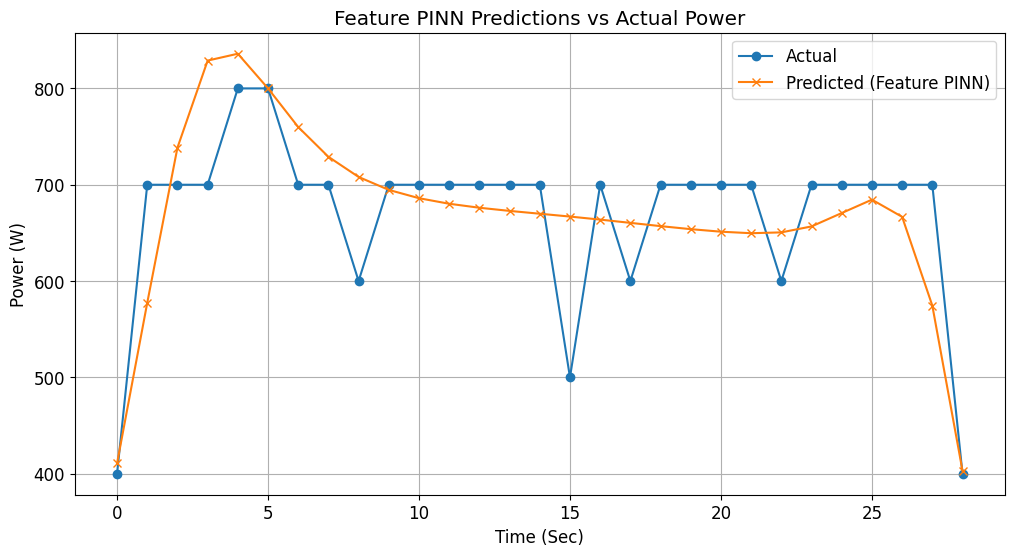

In [ ]:
# ==============================
# Save, Load & Predict with Feature PINN
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# ----------------------
# 1. Save Feature PINN
# ----------------------
pinn_pg.save("pinn_feature_model.keras")
print("✅ Feature PINN model saved!")

# ----------------------
# 2. Load Feature PINN
# ----------------------
pinn_pg_loaded = keras.models.load_model("pinn_feature_model.keras")
print("✅ Feature PINN model loaded!")

# ----------------------
# 3. Prepare New Data
# ----------------------
new_data = {
    "Feed Rate": [384]*29,        # mm/min
    "Depth Of Cut (mm)": [4]*29,  # mm
    "Spindle Speed": [1920]*29,   # rpm
    "Time (Sec)": list(range(0,29)), # time steps
    "Actual P (w)": [
        400,700,700,700,800,800,700,700,600,700,
        700,700,700,700,700,500,700,600,700,700,
        700,700,600,700,700,700,700,700,400
    ]
}
df_new = pd.DataFrame(new_data)

# Extract features
X_new_raw = df_new[["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]].values
y_true = df_new["Actual P (w)"].values

# Scale features
X_new_scaled = scaler_X.transform(X_new_raw)

# Add physics-guided feature
X_new_pg = add_physics_feature(X_new_raw, X_new_scaled)

# ----------------------
# 4. Predict with Loaded Feature PINN
# ----------------------
y_new_pred_scaled = pinn_pg_loaded.predict(X_new_pg)
y_new_pred = scaler_y.inverse_transform(y_new_pred_scaled)

# Collect results
results_feature = pd.DataFrame({
    "Time (Sec)": df_new["Time (Sec)"],
    "Actual P (w)": y_true,
    "Predicted P (w) (Feature PINN)": y_new_pred.flatten()
})
print("\n🔹 Results (First 10 rows):")
print(results_feature.head(10))

# ----------------------
# 5. Plot Actual vs Predicted
# ----------------------
plt.figure(figsize=(12,6))
plt.plot(results_feature["Time (Sec)"], results_feature["Actual P (w)"], label="Actual", marker="o")
plt.plot(results_feature["Time (Sec)"], results_feature["Predicted P (w) (Feature PINN)"],
         label="Predicted (Feature PINN)", marker="x")
plt.xlabel("Time (Sec)")
plt.ylabel("Power (W)")
plt.title("Feature PINN Predictions vs Actual Power")
plt.legend()
plt.grid(True)
plt.show()


✅ ANN model saved!
✅ ANN model loaded!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step

🔹 Results (First 10 rows):
   Time (Sec)  Actual P (w)  Predicted P (w) (ANN)
0           0           400             513.205261
1           1           700             709.442505
2           2           700             764.962463
3           3           700             788.024353
4           4           800             807.350037
5           5           800             790.735168
6           6           700             771.152771
7           7           700             750.324829
8           8           600             733.830383
9           9           700             719.808777


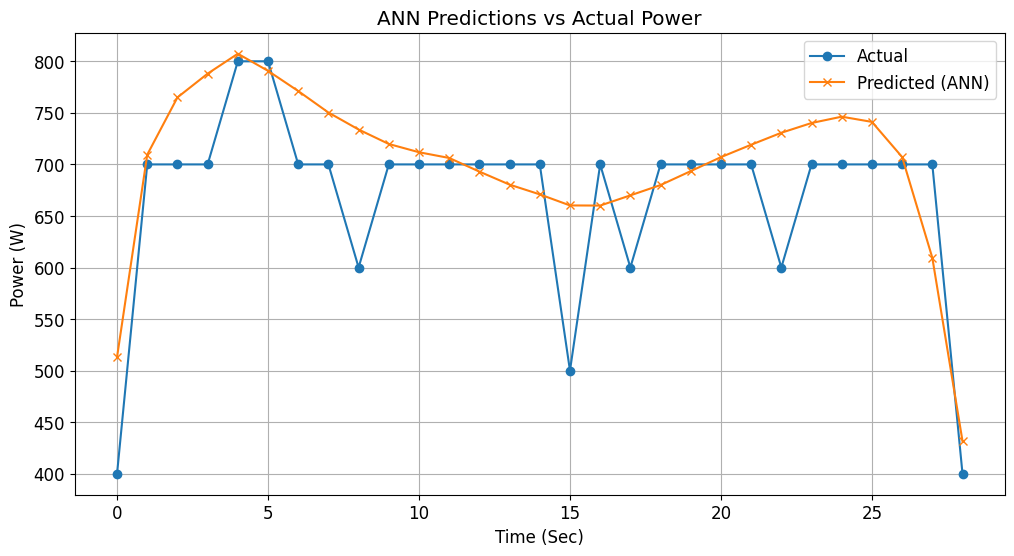

In [ ]:
# ==============================
# Save, Load & Predict with ANN
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# ----------------------
# 1. Save ANN
# ----------------------
ann.save("ann_model.keras")
print("✅ ANN model saved!")

# ----------------------
# 2. Load ANN
# ----------------------
ann_loaded = keras.models.load_model("ann_model.keras")
print("✅ ANN model loaded!")

# ----------------------
# 3. Prepare New Data
# ----------------------
new_data = {
    "Feed Rate": [384]*29,        # mm/min
    "Depth Of Cut (mm)": [4]*29,  # mm
    "Spindle Speed": [1920]*29,   # rpm
    "Time (Sec)": list(range(0,29)), # time steps
    "Actual P (w)": [
        400,700,700,700,800,800,700,700,600,700,
        700,700,700,700,700,500,700,600,700,700,
        700,700,600,700,700,700,700,700,400
    ]
}
df_new = pd.DataFrame(new_data)

# Extract features
X_new_raw = df_new[["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]].values
y_true = df_new["Actual P (w)"].values

# Scale features (same scaler_X as training)
X_new_scaled = scaler_X.transform(X_new_raw)

# ----------------------
# 4. Predict with Loaded ANN
# ----------------------
y_new_pred_scaled = ann_loaded.predict(X_new_scaled)
y_new_pred = scaler_y.inverse_transform(y_new_pred_scaled)

# Collect results
results_ann = pd.DataFrame({
    "Time (Sec)": df_new["Time (Sec)"],
    "Actual P (w)": y_true,
    "Predicted P (w) (ANN)": y_new_pred.flatten()
})
print("\n🔹 Results (First 10 rows):")
print(results_ann.head(10))

# ----------------------
# 5. Plot Actual vs Predicted
# ----------------------
plt.figure(figsize=(12,6))
plt.plot(results_ann["Time (Sec)"], results_ann["Actual P (w)"], label="Actual", marker="o")
plt.plot(results_ann["Time (Sec)"], results_ann["Predicted P (w) (ANN)"],
         label="Predicted (ANN)", marker="x")
plt.xlabel("Time (Sec)")
plt.ylabel("Power (W)")
plt.title("ANN Predictions vs Actual Power")
plt.legend()
plt.grid(True)
plt.show()


✅ All models loaded!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


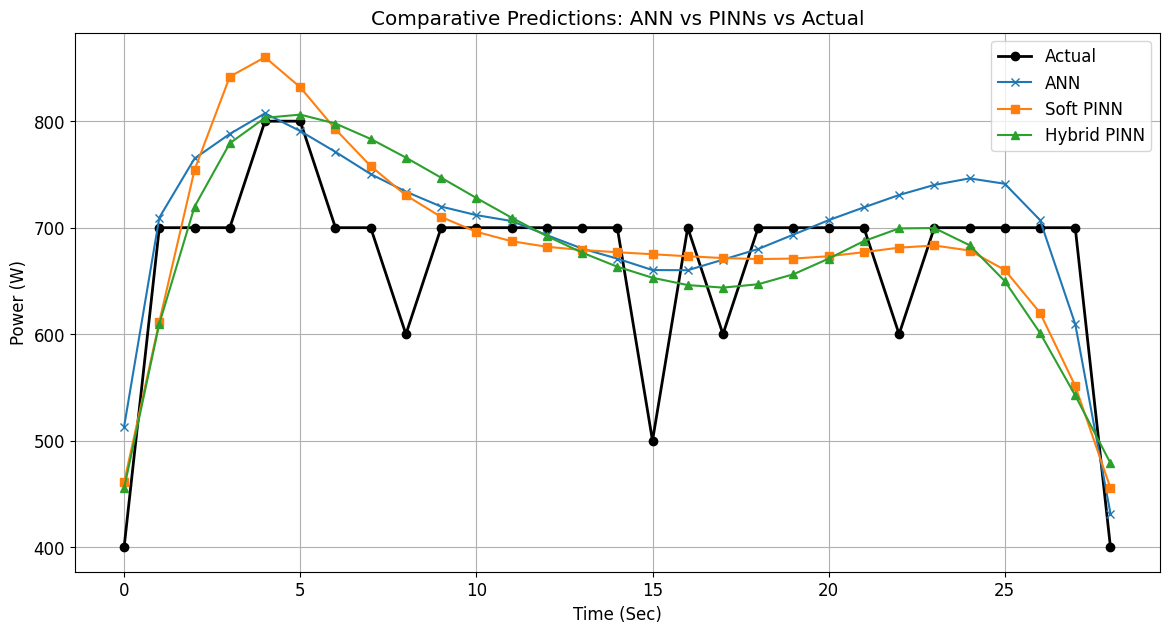

In [ ]:
# ==============================
# Compare ANN, Soft PINN, Hybrid PINN, Feature PINN
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# ----------------------
# 1. Load Saved Models
# ----------------------
ann_loaded = keras.models.load_model("ann_model.keras")
pinn_soft_loaded = keras.models.load_model("pinn_soft_model.keras", compile=False)
pinn_hybrid_loaded = keras.models.load_model("pinn_hybrid_model.keras", compile=False)
pinn_feature_loaded = keras.models.load_model("pinn_feature_model.keras")

print("✅ All models loaded!")

# ----------------------
# 2. Prepare New Data
# ----------------------
new_data = {
    "Feed Rate": [384]*29,
    "Depth Of Cut (mm)": [4]*29,
    "Spindle Speed": [1920]*29,
    "Time (Sec)": list(range(0,29)),
    "Actual P (w)": [
        400,700,700,700,800,800,700,700,600,700,
        700,700,700,700,700,500,700,600,700,700,
        700,700,600,700,700,700,700,700,400
    ]
}
df_new = pd.DataFrame(new_data)

X_new_raw = df_new[["Feed Rate", "Depth Of Cut (mm)", "Spindle Speed", "Time (Sec)"]].values
y_true = df_new["Actual P (w)"].values
X_new_scaled = scaler_X.transform(X_new_raw)

# For Feature PINN
X_new_pg = add_physics_feature(X_new_raw, X_new_scaled)

# ----------------------
# 3. Predictions
# ----------------------
# ANN
y_pred_ann_scaled = ann_loaded.predict(X_new_scaled)
y_pred_ann = scaler_y.inverse_transform(y_pred_ann_scaled)

# Soft PINN
y_pred_soft_scaled = pinn_soft_loaded.predict(X_new_scaled)
y_pred_soft = scaler_y.inverse_transform(y_pred_soft_scaled)

# Hybrid PINN (first output = data branch)
y_pred_hybrid_scaled, _ = pinn_hybrid_loaded.predict(X_new_scaled)
y_pred_hybrid = scaler_y.inverse_transform(y_pred_hybrid_scaled)

# Feature PINN
#y_pred_pg_scaled = pinn_feature_loaded.predict(X_new_pg)
#y_pred_pg = scaler_y.inverse_transform(y_pred_pg_scaled)

# ----------------------
# 4. Comparative Plot
# ----------------------
plt.figure(figsize=(14,7))
plt.plot(df_new["Time (Sec)"], y_true, label="Actual", color="black", marker="o", linewidth=2)
plt.plot(df_new["Time (Sec)"], y_pred_ann.flatten(), label="ANN", marker="x")
plt.plot(df_new["Time (Sec)"], y_pred_soft.flatten(), label="Soft PINN", marker="s")
plt.plot(df_new["Time (Sec)"], y_pred_hybrid.flatten(), label="Hybrid PINN", marker="^")
#plt.plot(df_new["Time (Sec)"], y_pred_pg.flatten(), label="Feature PINN", marker="d")

plt.xlabel("Time (Sec)")
plt.ylabel("Power (W)")
plt.title("Comparative Predictions: ANN vs PINNs vs Actual")
plt.legend()
plt.grid(True)
plt.show()
